In [ ]:
pip install numpy pandas scikit-learn matplotlib seaborn joblib


In [ ]:
#!/usr/bin/env python
import json
import numpy as np
import os
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def convert_timestamp(ts_str):
    try:
        h, m, s = ts_str.split(":")
        return int(h) * 3600 + int(m) * 60 + int(s)
    except:
        return 3600


def load_json_data(file_path):
    with open(file_path, "r") as f:
        return json.load(f)


def create_features(data):
    records = data.get("activityLog", [])
    if not records:
        return np.array([]), None

    feature_list, descriptions = [], []
    for rec in records:
        ts_val = convert_timestamp(rec.get("timeStampInVideo", "0:0:0"))
        count = rec.get("count", 0)
        description = rec.get("activityDescription", "")
        feature_list.append([ts_val, count])
        descriptions.append(description)

    encoder = LabelEncoder()
    desc_encoded = encoder.fit_transform(descriptions)
    features = np.hstack([np.array(feature_list), desc_encoded.reshape(-1, 1)])
    return features, encoder, descriptions


def apply_pca(features, variance_ratio=0.95):
    scaler = StandardScaler()
    print(features)
    scaled_features = scaler.fit_transform(features)
    pca = PCA(n_components=variance_ratio)
    reduced_features = pca.fit_transform(scaled_features)
    return reduced_features, scaler, pca

def apply_kmeans(features, n_clusters=3):
    n_clusters = min(n_clusters, len(features))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    return cluster_labels, kmeans


def train_isolation_forest(features):
    iso_model = IsolationForest(random_state=42, contamination='auto')
    iso_model.fit(features)
    return iso_model

def compute_cheating_score(model, features):
    scores = model.decision_function(features)
    anomalies = scores < 0
    cheating_score = anomalies.sum() / len(scores)
    return cheating_score

def save_model(iso_model, scaler, pca_model, kmeans_model, filename="enhanced_model.pkl"):
    joblib.dump({
        'isolation_forest': iso_model,
        'scaler': scaler,
        'pca': pca_model,
        'kmeans': kmeans_model
    }, filename)


def load_model(filename="enhanced_model.pkl"):
    if os.path.exists(filename):
        return joblib.load(filename)
    else:
        return None

def offline_training_pipeline(json_file):
    data = load_json_data(json_file)
    features, encoder = create_features(data)

    if features.size == 0:
        print("No activity detected. Saving empty model.")
        dummy_iso_model = IsolationForest().fit(np.zeros((1,3)))
        save_model(dummy_iso_model, None, None, None)
        return

    reduced_features, scaler, pca_model = apply_pca(features)
    cluster_labels, kmeans_model = apply_kmeans(reduced_features)

    enhanced_features = np.hstack([reduced_features, cluster_labels.reshape(-1,1)])

    iso_model = train_isolation_forest(enhanced_features)

    save_model(iso_model, scaler, pca_model, kmeans_model)

    cheating_score = compute_cheating_score(iso_model, enhanced_features)

    print(f"Offline training complete. Cheating Score: {cheating_score:.2f}")


def inference_pipeline(json_file):
    model_package = load_model()

    if model_package is None:
        raise Exception("Model not found. Please run offline training first.")

    iso_model = model_package['isolation_forest']
    scaler = model_package['scaler']
    pca_model = model_package['pca']
    kmeans_model = model_package['kmeans']

    data = load_json_data(json_file)

    features, encoder, descriptions = create_features(data)

    if features.size == 0:
        print("No activity detected. Cheating Score: 0.00")
        return 0.0

    scaled_features = scaler.transform(features)
    reduced_features = pca_model.transform(scaled_features)

    cluster_labels = kmeans_model.predict(reduced_features)

    enhanced_features = np.hstack([reduced_features, cluster_labels.reshape(-1,1)])

    cheating_score = compute_cheating_score(iso_model, enhanced_features)

    print(f"Inference complete. Cheating Score: {cheating_score:.2f}")

    return cheating_score


In [ ]:
def create_features(data):
    records = data.get("activityLog", [])
    if not records:
        return np.array([]), None, []

    feature_list, descriptions = [], []
    for rec in records:
        ts_val = convert_timestamp(rec.get("timeStampInVideo", "0:0:0"))
        count = rec.get("count", 0)
        description = rec.get("activityDescription", "")
        feature_list.append([ts_val, count])
        descriptions.append(description)

    encoder = LabelEncoder()
    desc_encoded = encoder.fit_transform(descriptions)
    features = np.hstack([np.array(feature_list), desc_encoded.reshape(-1, 1)])
    return features, encoder, descriptions

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def visualize_activity_data(json_file):
    data = load_json_data(json_file)
    records = data.get("activityLog", [])

    if not records:
        print("No activity data to visualize")
        return

    df = pd.DataFrame(records)
    df['seconds'] = df['timeStampInVideo'].apply(convert_timestamp)

    df = df.sort_values('seconds')

    fig, axes = plt.subplots(3, 1, figsize=(12, 15))

    ax = axes[0]
    sns.scatterplot(x='seconds', y='activityDescription', data=df,
                    size='count', sizes=(20, 200), ax=ax)
    ax.set_title('Activity Timeline')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Activity Type')
    ax = axes[1]
    activity_counts = df['activityDescription'].value_counts()
    activity_counts.plot(kind='barh', ax=ax)
    ax.set_title('Activity Frequency')
    ax.set_xlabel('Count')
    ax = axes[2]
    bin_size = 60
    max_time = df['seconds'].max()
    bins = list(range(0, max_time + bin_size, bin_size))
    df['time_bin'] = pd.cut(df['seconds'], bins)

    activity_density = df.groupby('time_bin').size()
    activity_density.plot(kind='bar', ax=ax)
    ax.set_title('Activity Density Over Time')
    ax.set_xlabel('Time Range (seconds)')
    ax.set_ylabel('Number of Activities')

    plt.tight_layout()
    plt.savefig(f"{json_file.split('.')[0]}_visualization.png")
    plt.show()

    plt.figure(figsize=(14, 8))

    time_bins = pd.cut(df['seconds'], bins)
    heatmap_data = pd.crosstab(time_bins, df['activityDescription'])

    sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=.5)
    plt.title('Activity Patterns Over Time')
    plt.xlabel('Activity Type')
    plt.ylabel('Time Range (seconds)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{json_file.split('.')[0]}_heatmap.png")
    plt.show()

In [ ]:
def predict():
    json_file = "candidate45.json"
    if not os.path.exists(json_file):
        print(f"[Warning] {json_file} not found. Skipping...")
        return
    visualize_activity_data(json_file)
    inference_pipeline(json_file)

Processing candidate1.json...
Processing candidate2.json...
Processing candidate3.json...
Processing candidate4.json...
Processing candidate5.json...
Processing candidate6.json...
Processing candidate7.json...
Processing candidate8.json...
Processing candidate9.json...
Processing candidate10.json...
Processing candidate11.json...
Processing candidate12.json...
Processing candidate13.json...
Processing candidate14.json...
Processing candidate15.json...
[Warning] candidate16.json not found. Skipping...
Processing candidate17.json...
Processing candidate18.json...
Processing candidate19.json...
Processing candidate20.json...
Processing candidate21.json...
Processing candidate22.json...
Processing candidate23.json...
Processing candidate24.json...
Processing candidate25.json...
Processing candidate26.json...
Processing candidate27.json...
Processing candidate28.json...
Processing candidate29.json...
Processing candidate30.json...
Processing candidate31.json...
Processing candidate32.json..

<ipython-input-14-b9538929778c>:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  activity_density = df.groupby('time_bin').size()


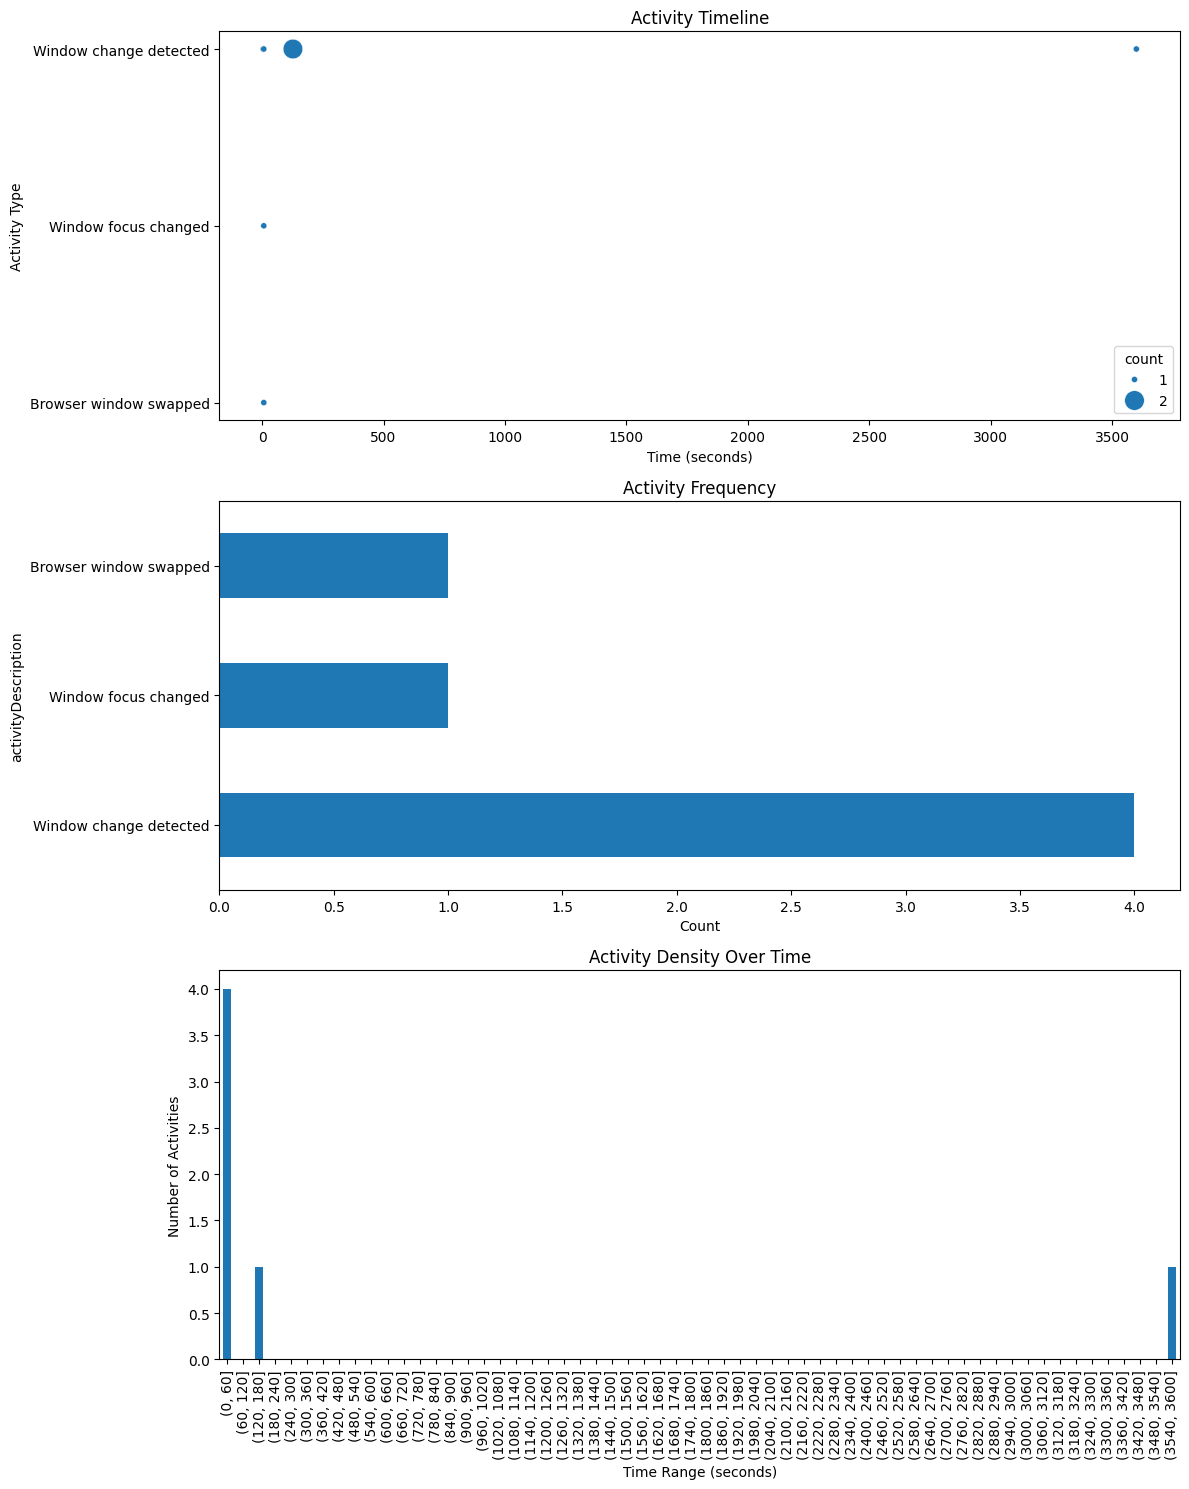

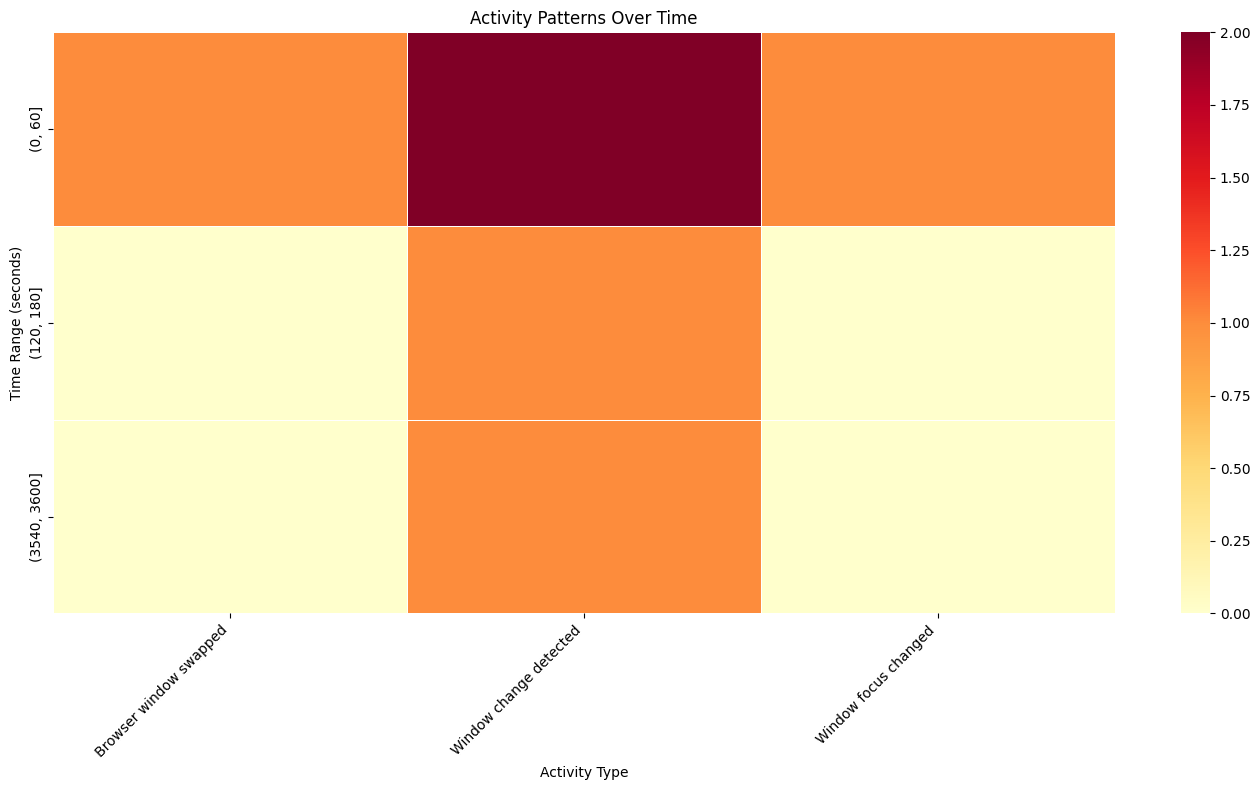

Inference complete. Cheating Score: 0.83


In [ ]:
if __name__ == "__main__":
    all_features = []


    for i in range(1, 41):
        json_file = f"candidate{i}.json"
        if not os.path.exists(json_file):
            print(f"[Warning] {json_file} not found. Skipping...")
            continue

        print(f"Processing {json_file}...")
        data = load_json_data(json_file)
        features, encoder, descriptions = create_features(data)

        if features.size == 0:
            print(f"[Info] No activity detected in {json_file}, skipping feature aggregation.")
            continue

        all_features.append(features)

    if len(all_features) == 0:
        raise Exception("No valid data found in any JSON files. Cannot train model.")

    combined_features = np.vstack(all_features)
    reduced_features, scaler, pca_model = apply_pca(combined_features)
    cluster_labels, kmeans_model = apply_kmeans(reduced_features)
    enhanced_features = np.hstack([reduced_features, cluster_labels.reshape(-1, 1)])
    iso_model = train_isolation_forest(enhanced_features)
    save_model(iso_model, scaler, pca_model, kmeans_model)
    predict()
